# Pset4.6

In [1]:
from __future__ import print_function, division
from cart_pole import CartPole, Physics
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

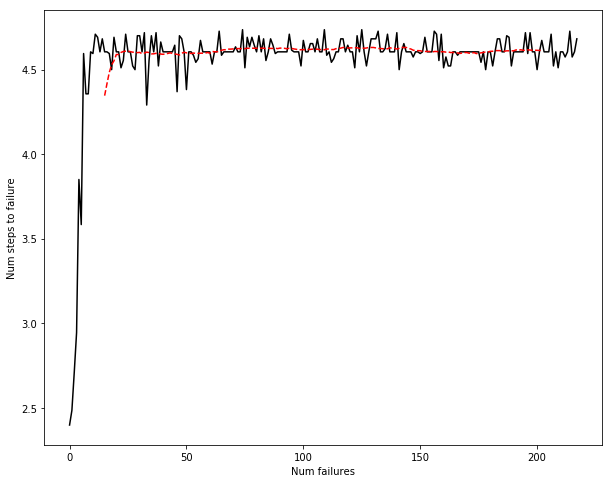

In [63]:
# Simulation parameters
pause_time = 0.0001
min_trial_length_to_start_display = 100
display_started = min_trial_length_to_start_display == 0

NUM_STATES = 163
NUM_ACTIONS = 2
GAMMA = 0.995
TOLERANCE = 0.01
NO_LEARNING_THRESHOLD = 20

# Time cycle of the simulation
time = 0

# These variables perform bookkeeping (how many cycles was the pole
# balanced for before it fell). Useful for plotting learning curves.
time_steps_to_failure = []
num_failures = 0
time_at_start_of_current_trial = 0

# You should reach convergence well before this
max_failures = 500

# Initialize a cart pole
cart_pole = CartPole(Physics())

# Starting `state_tuple` is (0, 0, 0, 0)
# x, x_dot, theta, theta_dot represents the actual continuous state vector
x, x_dot, theta, theta_dot = 0.0, 0.0, 0.0, 0.0
state_tuple = (x, x_dot, theta, theta_dot)

# `state` is the number given to this state, you only need to consider
# this representation of the state
state = cart_pole.get_state(state_tuple)
# if min_trial_length_to_start_display == 0 or display_started == 1:
#     cart_pole.show_cart(state_tuple, pause_time)

# Perform all your initializations here:
# Assume no transitions or rewards have been observed.
# Initialize the value function array to small random values (0 to 0.10,
# say).
# Initialize the transition probabilities uniformly (ie, probability of
# transitioning for state x to state y using action a is exactly
# 1/NUM_STATES).
# Initialize all state rewards to zero.

###### BEGIN YOUR CODE ######
uniform_prob = 1/NUM_STATES
ACTIONS = [0,1]
V = np.random.randn(NUM_STATES) * 0.1
Csa = np.zeros((NUM_STATES, 2, NUM_STATES))
Psa = np.ones((NUM_STATES, 2, NUM_STATES))*uniform_prob
Rh = np.zeros(NUM_STATES)
###### END YOUR CODE ######

# This is the criterion to end the simulation.
# You should change it to terminate when the previous
# 'NO_LEARNING_THRESHOLD' consecutive value function computations all
# converged within one value function iteration. Intuitively, it seems
# like there will be little learning after this, so end the simulation
# here, and say the overall algorithm has converged.

consecutive_no_learning_trials = 0
while consecutive_no_learning_trials < NO_LEARNING_THRESHOLD:

    # Write code to choose action (0 or 1).
    # This action choice algorithm is just for illustration. It may
    # convince you that reinforcement learning is nice for control
    # problems!Replace it with your code to choose an action that is
    # optimal according to the current value function, and the current MDP
    # model.
    ###### BEGIN YOUR CODE ######

    ## policy iteration
    action = np.argmax(GAMMA * np.dot(Psa[state],V))
    
    ###### END YOUR CODE ######

    # Get the next state by simulating the dynamics
    state_tuple = cart_pole.simulate(action, state_tuple)
    # x, x_dot, theta, theta_dot = state_tuple

    # Increment simulation time
    time = time + 1

    # Get the state number corresponding to new state vector
    new_state = cart_pole.get_state(state_tuple)
    # if display_started == 1:
    #     cart_pole.show_cart(state_tuple, pause_time)

    # reward function to use - do not change this!
    if new_state == NUM_STATES - 1:
        R = -1
    else:
        R = 0

    # Perform model updates here.
    # A transition from `state` to `new_state` has just been made using
    # `action`. The reward observed in `new_state` (note) is `R`.
    # Write code to update your statistics about the MDP i.e. the
    # information you are storing on the transitions and on the rewards
    # observed. Do not change the actual MDP parameters, except when the
    # pole falls (the next if block)!

    ###### BEGIN YOUR CODE ######
    Rh[new_state] = R
    Csa[state][action][new_state] += 1
    
    # record the number of times `state, action, new_state` occurs
    # record the rewards for every `new_state`
    # record the number of time `new_state` was reached
    ###### END YOUR CODE ######

    # Recompute MDP model whenever pole falls
    # Compute the value function V for the new model
    if new_state == NUM_STATES - 1:

        # Update MDP model using the current accumulated statistics about the
        # MDP - transitions and rewards.
        # Make sure you account for the case when a state-action pair has never
        # been tried before, or the state has never been visited before. In that
        # case, you must not change that component (and thus keep it at the
        # initialized uniform distribution).

        ###### BEGIN YOUR CODE ######   
        
        ## update Psa
        to_update_ind = np.where(Csa>0)[0:2] ## only grab s,a pairs
        Psa[to_update_ind] = Csa[to_update_ind]/np.sum(Csa[to_update_ind], axis=1, keepdims=True)
        
        ###### END YOUR CODE ######

        # Perform value iteration using the new estimated model for the MDP.
        # The convergence criterion should be based on `TOLERANCE` as described
        # at the top of the file.
        # If it converges within one iteration, you may want to update your
        # variable that checks when the whole simulation must end.

        ###### BEGIN YOUR CODE ######
        ## value iteration
        old_V = np.copy(V)
        V = Rh + np.max(GAMMA * np.dot(Psa, V), axis=1)

        diff = np.max(np.abs(old_V-V))
        if diff < TOLERANCE:
            consecutive_no_learning_trials+=1
        else:
            consecutive_no_learning_trials=0
                
        ###### END YOUR CODE ######

    # Do NOT change this code: Controls the simulation, and handles the case
    # when the pole fell and the state must be reinitialized.
    if new_state == NUM_STATES - 1:
        num_failures += 1
        if num_failures >= max_failures:
            break
        #print('[INFO] Failure number {}'.format(num_failures))
        time_steps_to_failure.append(time - time_at_start_of_current_trial)
        # time_steps_to_failure[num_failures] = time - time_at_start_of_current_trial
        time_at_start_of_current_trial = time

        if time_steps_to_failure[num_failures - 1] > min_trial_length_to_start_display:
            display_started = 1

        # Reinitialize state
        # x = 0.0
        x = -1.1 + np.random.uniform() * 2.2
        x_dot, theta, theta_dot = 0.0, 0.0, 0.0
        state_tuple = (x, x_dot, theta, theta_dot)
        state = cart_pole.get_state(state_tuple)
    else:
        state = new_state

# plot the learning curve (time balanced vs. trial)
log_tstf = np.log(np.array(time_steps_to_failure))
plt.plot(np.arange(len(time_steps_to_failure)), log_tstf, 'k')
window = 30
w = np.array([1/window for _ in range(window)])
weights = lfilter(w, 1, log_tstf)
x = np.arange(window//2, len(log_tstf) - window//2)
plt.plot(x, weights[window:len(log_tstf)], 'r--')
plt.xlabel('Num failures')
plt.ylabel('Num steps to failure')
plt.show()
